### Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Preprocessing

## Feature Scaling & File Sorting

In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import glob

# input and output directories
root_dir = '/Users/joshuavargas/research/datasets/BB-MAS_Dataset/BB-MAS_Dataset/'
output_base_dir = '/Users/joshuavargas/research/datasets/BB-MAS_Preprocessed/'

# distinguish between accelerometer and gyroscope data
sensor_types = {'Accelerometer': 'accelerometer', 'Gyroscope': 'gyroscope'}

# folders 1 - 117
for i in range(1, 118):
    folder_path = os.path.join(root_dir, str(i))
    csv_files = glob.glob(os.path.join(folder_path, '*_PocketPhone_*.csv'))
    
    if not csv_files:
        continue
    
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        
        # copy the features that aren't being normalized then normalize to be between -1 and 1
        output_df = df[['time']].copy()
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        for column in ['Xvalue', 'Yvalue', 'Zvalue']:
            scaled_values = scaler.fit_transform(df[[column]])
            output_df[column] = scaled_values
            
        # convert timestamp to panda datetime -> calculate elapsed times -> drop original timestamp
        output_df['time'] = pd.to_datetime(output_df['time'])
        output_df['elapsed_time'] = output_df['time'].diff().dt.total_seconds().fillna(0)
        output_df.drop(columns=['time'], inplace=True)
        
        # determine sensor type for output directory
        for sensor_key, sensor_folder in sensor_types.items():
            if sensor_key in csv_file:
                sensor_output_dir = os.path.join(output_base_dir, sensor_folder)
                break
        else:
            sensor_output_dir = os.path.join(output_base_dir, 'other')
        
        # make sure folders exist and set output file names to be the input file name
        os.makedirs(sensor_output_dir, exist_ok=True)
        output_filename = os.path.basename(csv_file)
        
        # Write to file in the specific sensor type folder
        output_df.to_csv(os.path.join(sensor_output_dir, output_filename), index=False)


## Resizing 

In [34]:
import pandas
import os
import glob

folder_path_accelerometer = '/Users/joshuavargas/research/datasets/BB-MAS_Preprocessed/accelerometer/'
folder_path_gyroscope = '/Users/joshuavargas/research/datasets/BB-MAS_Preprocessed/gyroscope/'

csv_files_accelerometer = glob.glob(os.path.join(folder_path, '*_PocketPhone_*.csv'))
csv_files_gyroscope = glob.glob(os.path.join(folder_path, '*_PocketPhone_*.csv'))
num_rows = 1000000

for csv_file in csv_files_accelerometer:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)
    if df.shape[0] < num_rows:
        num_rows = df.shape[0]
        #print(f'{file_name}: {num_rows}')
    #print(f'{file_name}: {df.shape[0]}')

print("least number of rows in accelerometer folder: ", num_rows)

num_rows = 1000000

for csv_file in csv_files_gyroscope:
    df = pd.read_csv(csv_file)
    file_name = os.path.basename(csv_file)
    if df.shape[0] < num_rows:
        num_rows = df.shape[0]
        #print(f'{file_name}: {num_rows_gyroscope}')
    #print(f'{file_name}: {df.shape[0]}')

print("least number of rows in gyroscope folder: ", num_rows)


least number of rows in accelerometer folder:  17024
least number of rows in gyroscope folder:  17024


## Sequencing

In [ ]:
import numpy as np

# Assuming df is your DataFrame and has been sorted by time
sequence_length = 50  # Example sequence length

features = df[['Xvalue', 'Yvalue', 'Zvalue', 'elapsed_time']].values
num_sequences = int(np.floor(features.shape[0] / sequence_length))

X = np.zeros((num_sequences, sequence_length, features.shape[1]))  # Placeholder for input sequences

for i in range(num_sequences):
    X[i] = features[i*sequence_length:(i+1)*sequence_length]

# Assuming y is a numpy array with your labels
y = np.array([your_label_logic_here for _ in range(num_sequences)])  # Adjust label logic as needed


## Scale Verification 

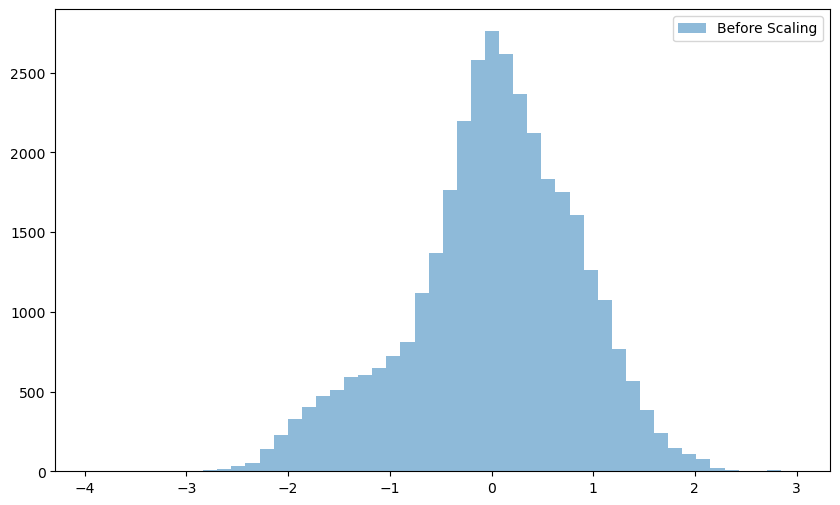

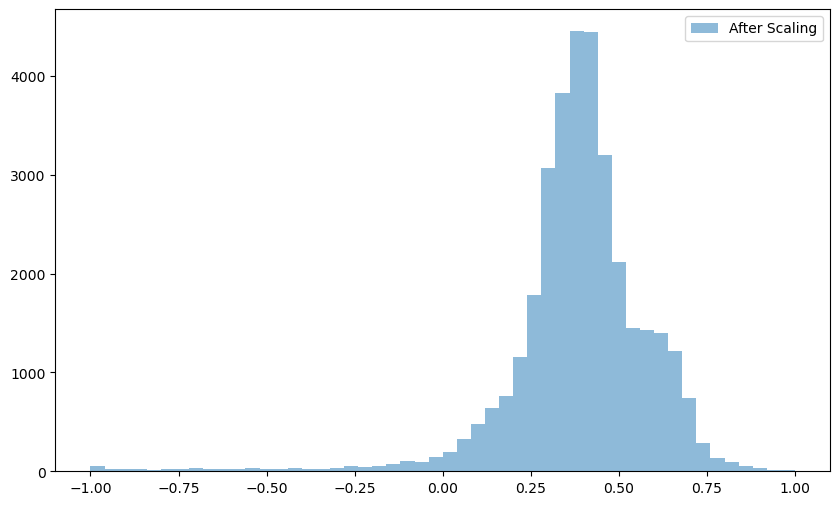

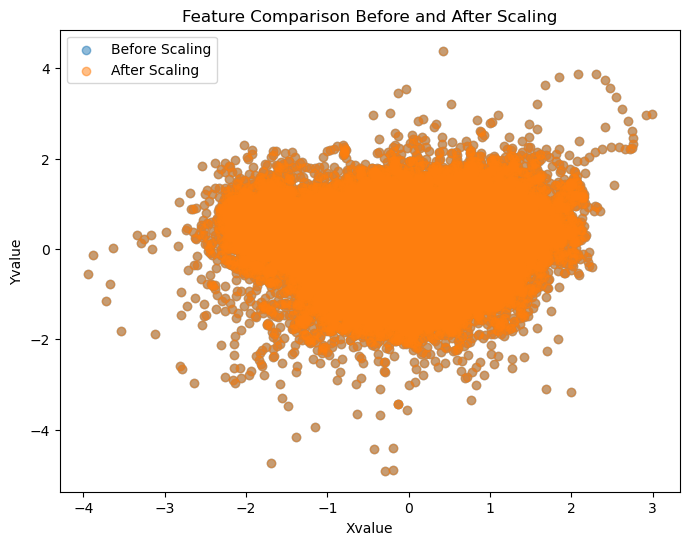

In [35]:
import matplotlib.pyplot as plt

root_dir   = '/Users/joshuavargas/research/datasets/BB-MAS_Dataset/BB-MAS_Dataset/'
output_dir = '/Users/joshuavargas/research/datasets/BB-MAS_Preprocessed/accelerometer/'

folder_path = os.path.join(root_dir, "1")
csv_files = glob.glob(os.path.join(folder_path, '*_PocketPhone_*.csv'))
scaled_files = glob.glob(os.path.join(output_dir, '1_PocketPhone_*.csv'))

df = pd.read_csv(csv_files[0])
X_train = df['Xvalue']
X_scatter = df[['Xvalue', 'Yvalue']]

df_scaled = pd.read_csv(scaled_files[0])
X_train_scaled = df_scaled['Xvalue']
X_scatter_scaled = df[['Xvalue', 'Yvalue']]

# histograms
# before scaling
plt.figure(figsize=(10, 6))
plt.hist(X_train, bins=50, alpha=0.5, label='Before Scaling')
plt.legend()
plt.show()

# after scaling
plt.figure(figsize=(10, 6))
plt.hist(X_train_scaled, bins=50, alpha=0.5, label='After Scaling')
plt.legend()
plt.show()

# scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_scatter['Xvalue'], X_scatter['Yvalue'], alpha=0.5, label='Before Scaling')
plt.scatter(X_scatter_scaled['Xvalue'], X_scatter_scaled['Yvalue'], alpha=0.5, label='After Scaling')
plt.title("Feature Comparison Before and After Scaling")
plt.xlabel("Xvalue")
plt.ylabel("Yvalue")
plt.legend()
plt.show()



# LSTM Creation